In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk 
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [30]:
# This is a Kaggle competition where we will develop algorithms to classify 
# genetic mutations based on clinical evidence (text).

In [2]:
# Reading File and spliting lines
# Text dataset
with open('projeto7-data_files/data_files/training_text', 'r', encoding='utf8') as f:
    training_text = f.read()
    training_text = training_text.splitlines()
# Variants dataset 
with open('projeto7-data_files/data_files/training_variants ', 'r', encoding='utf8') as f:
    training_variants = f.read()
    training_variants = training_variants.splitlines()

In [3]:
%%time
# Spliting Text line with '||' delimiter
training_text_split = [line.split('||') for line in training_text]

# Spliting Variants with ',' delimiter
training_variants_split = [line.split(',') for line in training_variants]

Wall time: 230 ms


In [4]:
# Deleting Header Row
# Text dataset
training_text_split.pop(0)
training_text_split = pd.DataFrame(training_text_split,columns=['ID','Text'])

# Variants dataset
training_variants_split.pop(0)
training_variants_split = pd.DataFrame(training_variants_split,columns=['ID','Gene','Variation','Class'])

# Merging dataset by ID
train_data = training_variants_split.merge(training_text_split, how='inner', on='ID')
train_data = train_data.drop('ID',axis=1)
train_data.head()

,Gene,Variation,Class,Text
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
train_data.isna().sum()

Gene         0
Variation    0
Class        0
Text         0
dtype: int64

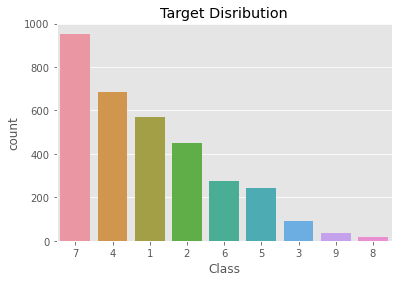

In [6]:
# PLotting the Target
sns.countplot(x="Class", data=train_data, order = train_data['Class'].value_counts().index)
plt.title("Target Disribution")
plt.show()

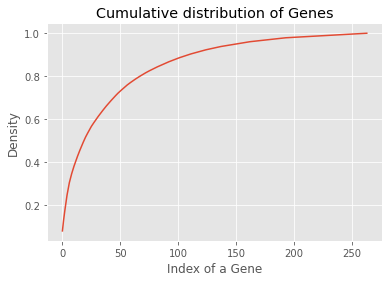

In [7]:
# Plotting genes
genes = train_data["Gene"].value_counts()
total_genes = genes.values/sum(genes.values)

plt.plot(np.cumsum(total_genes))
plt.xlabel("Index of a Gene")
plt.ylabel("Density")
plt.title("Cumulative distribution of Genes")
plt.show()

In [8]:
# Creating a function to tokenize and Stem the text
def SentenceStemmer(sentence):
    # replace every special char with space
    sentence = re.sub('[^a-zA-Z0-9\n]', ' ', sentence)
    # replace multiple spaces with single space
    sentence = re.sub('\s+',' ', sentence)
    # Tokenizing
    tokens = word_tokenize(str.lower(sentence))
    stems = [PorterStemmer().stem(token) for token in tokens]
    return " ".join(stems)

In [9]:
%%time
train_data['Stemmed_Text'] = train_data['Text'].apply(SentenceStemmer)

Wall time: 14min 48s


In [10]:
train_data.head()

,Gene,Variation,Class,Text,Stemmed_Text
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin depend kinas cdk regul a varieti of fun...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cancer...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cancer...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,recent evid ha demonstr that acquir uniparent ...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,oncogen mutat in the monomer casita b lineag l...


In [11]:
# Spliting X and y
X = train_data.drop(['Text', 'Class'], axis=1)
y = train_data['Class'].values
# Removing 1 of y for the first class starts with 0 index
y = y.astype(int)-1

# Spliting into train and text
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y)

In [12]:
# Spliting into train and validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.1,
                                                                stratify=y_train)

X_train.shape,X_test.shape,X_validation.shape

((2689, 3), (333, 3), (299, 3))

In [13]:
## Pipeline for preprocess X
# Creating custom transformation for the text
text_features = "Stemmed_Text"
text_transformer = Pipeline(
    steps=[('vect', CountVectorizer(stop_words='english')), 
           ('tfidf', TfidfTransformer())]
)

# One Hot encoding for categoricals columns
categorical_features = ['Gene','Variation']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Passing the parameters
preprocessor = ColumnTransformer(
    transformers=[
        ("txt", text_transformer, text_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Finishing pipeline
pre_process = Pipeline(
    steps=[("preprocessor", preprocessor)]
)

In [14]:
%%time
# Applying pipeline
X_train_preprocced = pre_process.fit_transform(X_train)
X_test_preprocced = pre_process.transform(X_test)
X_validation_preprocced = pre_process.transform(X_validation)

X_train_preprocced.shape, X_test_preprocced.shape,X_validation_preprocced.shape

Wall time: 20.9 s


((2689, 128412), (333, 128412), (299, 128412))

In [15]:
# Trainning a simple model to see results in test data
clf = MultinomialNB().fit(X_train_preprocced,y_train)
print(metrics.classification_report(y_test,clf.predict(X_test_preprocced)))
print(metrics.confusion_matrix(y_test, clf.predict(X_test_preprocced)))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61        57
           1       1.00      0.07      0.12        45
           2       0.00      0.00      0.00         9
           3       0.68      0.83      0.75        69
           4       0.75      0.25      0.38        24
           5       0.94      0.61      0.74        28
           6       0.54      1.00      0.70        95
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4

    accuracy                           0.63       333
   macro avg       0.51      0.37      0.37       333
weighted avg       0.68      0.63      0.57       333

[[31  0  0 17  0  0  9  0  0]
 [ 0  3  0  0  0  0 42  0  0]
 [ 1  0  0  2  0  0  6  0  0]
 [ 7  0  0 57  0  0  5  0  0]
 [ 4  0  0  8  6  1  5  0  0]
 [ 1  0  0  0  2 17  8  0  0]
 [ 0  0  0  0  0  0 95  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


In [16]:
## Neural Network
# Transforming y to dummy variable
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)
y_validation_encoded = tf.keras.utils.to_categorical(y_validation)

In [17]:
# Unbalanced classes in the target, so we will create class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_dict = dict(enumerate(class_weights))

# configure early stopping
es = EarlyStopping(monitor='val_loss', patience=5)

In [26]:
# Creating keras sequential model
model = Sequential()
model.add(Dense(8, input_dim=X_train_preprocced.shape[1], activation='relu',kernel_regularizer='l2'))
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))#,kernel_regularizer='l2'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))
# Compiling model
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 1027304   
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 12)                108       
                                                                 
 dense_8 (Dense)             (None, 9)                 117       
                                                                 
Total params: 1,027,529
Trainable params: 1,027,529
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time
# Training the model
history = model.fit(X_train_preprocced, y_train_encoded, epochs = 200,
                    validation_data=(X_validation_preprocced,y_validation_encoded),
                    callbacks=[es],
                    class_weight=class_dict,
                    shuffle=True)

Epoch 1/200
85/85 [==============================] - 2s 14ms/step - loss: 2.1964 - accuracy: 0.2771 - val_loss: 2.1538 - val_accuracy: 0.4749
Epoch 2/200
85/85 [==============================] - 1s 12ms/step - loss: 2.1295 - accuracy: 0.4425 - val_loss: 2.0446 - val_accuracy: 0.5753
Epoch 3/200
85/85 [==============================] - 1s 12ms/step - loss: 2.0373 - accuracy: 0.4901 - val_loss: 1.8943 - val_accuracy: 0.5953
Epoch 4/200
85/85 [==============================] - 1s 12ms/step - loss: 1.9386 - accuracy: 0.5504 - val_loss: 1.7644 - val_accuracy: 0.5987
Epoch 5/200
85/85 [==============================] - 1s 12ms/step - loss: 1.8461 - accuracy: 0.5909 - val_loss: 1.6813 - val_accuracy: 0.5920
Epoch 6/200
85/85 [==============================] - 1s 12ms/step - loss: 1.7698 - accuracy: 0.5850 - val_loss: 1.6215 - val_accuracy: 0.5652
Epoch 7/200
85/85 [==============================] - 1s 12ms/step - loss: 1.7019 - accuracy: 0.6084 - val_loss: 1.5789 - val_accuracy: 0.6020
Epoch 

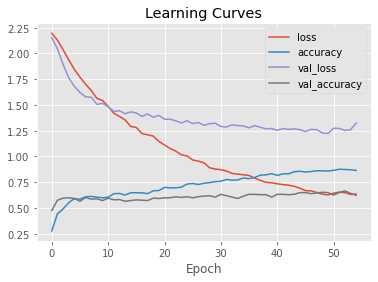

In [28]:
# plot learning curves
plt.plot(pd.DataFrame(history.history))
plt.legend(pd.DataFrame(history.history).columns)
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.show()

In [29]:
model.evaluate(X_test_preprocced,y_test_encoded)

11/11 [==============================] - 0s 5ms/step - loss: 1.1311 - accuracy: 0.6877


[1.131112813949585, 0.6876876950263977]

In [ ]:
# With this Neural Network we were able to increase slight the model accuracy